# Clockwork Axion

In [16]:
%run convergence.py
%run clockwork_axion.py

## Parameterspace from Paper

In [2]:
N = 10
m_phi_range = np.geomspace(1e-6, 1e6, N + 1) * 1e-9 # [GeV]
mR_range = np.linspace(1, 15, N)
sim_f_eff = f_eff = 1e13
H_inf = 1e8
Gamma_inf = H_inf

In [39]:
def fn(m_phi, mR, i, j, debug=False):
    eps = calc_eps(mR)
    f = calc_f(f_eff, eps)
    M = m_phi / eps
    ax0 = (theta_to_phi_over_f(1.0, eps), 0.0)
    n = i + j * len(m_phi_range) + 1
    print("step:", n, "of", len(m_phi_range) * len(mR_range), end="")
    start = time.time()
    try:
        x = compute_asymmetry(H_inf, Gamma_inf, (eps, M), f, 
            clockwork_axion_field, axion_init=ax0, calc_init_time=True, debug=debug, convergence_rtol=0.001)
    except ValueError as e:
        print(e)
        x = np.nan
    end = time.time()
    print(" done (%f seconds)" % (end - start))
    return x

In [40]:
%time eta = np.array([[fn(m_phi, mR, i, j) for i, m_phi in enumerate(m_phi_range)] for j, mR in enumerate(mR_range)])

step: 1 of 110 done (12.268463 seconds)
step: 2 of 110 done (11.135927 seconds)
step: 3 of 110 done (10.355329 seconds)
step: 4 of 110 done (4.109219 seconds)
step: 5 of 110 done (4.018708 seconds)
step: 6 of 110 done (3.832036 seconds)
step: 7 of 110 done (3.722903 seconds)
step: 8 of 110 done (3.765485 seconds)
step: 9 of 110 done (3.665552 seconds)
step: 10 of 110 done (3.569753 seconds)
step: 11 of 110

/home/jana/Documents/masters-project/transport_eq_in_time/transport_equation.py:150: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)


 done (3.346051 seconds)
step: 12 of 110 done (3.043421 seconds)
step: 13 of 110 done (3.224040 seconds)
step: 14 of 110 done (3.565567 seconds)
step: 15 of 110 done (3.891621 seconds)
step: 16 of 110 done (3.224796 seconds)
step: 17 of 110 done (3.109417 seconds)
step: 18 of 110 done (2.988004 seconds)
step: 19 of 110 done (2.934224 seconds)
step: 20 of 110 done (2.858797 seconds)
step: 21 of 110

/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:9: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)


 done (2.673754 seconds)
step: 22 of 110 done (2.634301 seconds)
step: 23 of 110 done (3.387175 seconds)
step: 24 of 110 done (3.381353 seconds)
step: 25 of 110 done (3.196563 seconds)
step: 26 of 110 done (2.972319 seconds)
step: 27 of 110 done (3.113832 seconds)
step: 28 of 110 done (3.066872 seconds)
step: 29 of 110 done (2.935940 seconds)
step: 30 of 110 done (2.823341 seconds)
step: 31 of 110 done (2.803623 seconds)
step: 32 of 110 done (2.313498 seconds)
step: 33 of 110 done (2.203808 seconds)
step: 34 of 110 done (3.128854 seconds)
step: 35 of 110 done (3.144213 seconds)
step: 36 of 110 done (3.181169 seconds)
step: 37 of 110 done (3.121533 seconds)
step: 38 of 110 done (2.991048 seconds)
step: 39 of 110 done (2.617782 seconds)
step: 40 of 110 done (2.821702 seconds)
step: 41 of 110 done (2.426749 seconds)
step: 42 of 110 done (2.569333 seconds)
step: 43 of 110 done (2.064512 seconds)
step: 44 of 110

/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:36: RuntimeWarning: invalid value encountered in double_scalars
  T = T_const * rho_rad**(1/4)
/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:37: RuntimeWarning: invalid value encountered in sqrt
  H = H_const * np.sqrt(rho_rad + rho_field)


 done (1.744304 seconds)
step: 45 of 110 done (3.335454 seconds)
step: 46 of 110 done (3.065842 seconds)
step: 47 of 110 done (3.167353 seconds)
step: 48 of 110 done (2.930907 seconds)
step: 49 of 110 done (3.288270 seconds)
step: 50 of 110 done (2.586222 seconds)
step: 51 of 110 done (2.754091 seconds)
step: 52 of 110 done (2.450556 seconds)
step: 53 of 110 done (1.865190 seconds)
step: 54 of 110 done (1.202045 seconds)
step: 55 of 110 done (1.030373 seconds)
step: 56 of 110 done (2.997457 seconds)
step: 57 of 110 done (2.851699 seconds)
step: 58 of 110 done (2.787450 seconds)
step: 59 of 110 done (2.687397 seconds)
step: 60 of 110 done (2.447175 seconds)
step: 61 of 110 done (2.391456 seconds)
step: 62 of 110 done (2.051684 seconds)
step: 63 of 110 done (1.353914 seconds)
step: 64 of 110 done (1.284863 seconds)
step: 65 of 110 done (1.124448 seconds)
step: 66 of 110 done (0.000010 seconds)
step: 67 of 110 done (2.886865 seconds)
step: 68 of 110 done (2.997838 seconds)
step: 69 of 110

Text(0, 0.5, 'mR')

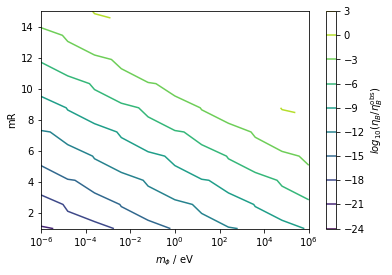

In [43]:
eta_observed = 6e-10 # from paper
plt.figure()
plt.contour(m_phi_range * 1e9, mR_range, np.log10(eta / eta_observed))
plt.xscale("log")
plt.colorbar(label=r"$log_{10}(\eta_B / \eta_B^\mathrm{obs})$")
plt.xlabel(r"$m_\phi$ / eV")
plt.ylabel(r"mR")

Text(0, 0.5, 'mR')

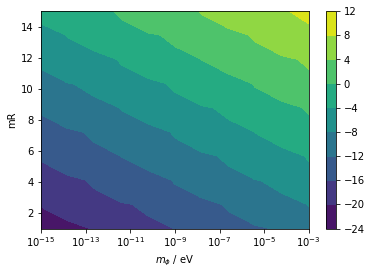

In [16]:
curvature = np.array([[calc_d2V_eff_dphi2(theta_to_phi_over_f(1.0, calc_eps(mR)), calc_eps(mR), m_phi / calc_eps(mR))
            for m_phi in m_phi_range] for mR in mR_range])
plt.contourf(m_phi_range * 1e9, mR_range, np.log10(np.sqrt(curvature) / H_inf) )
plt.xscale("log")
plt.colorbar()
plt.xlabel(r"$m_\phi$ / eV")
plt.ylabel(r"mR")

Text(0.5, 0, 'mR')

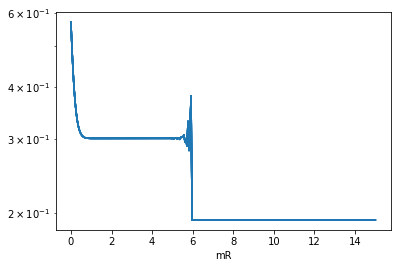

In [29]:
for m_phi in m_phi_range:
    mRs = np.linspace(0, 15, 300)
    A = np.array([calc_d2V_eff_dphi2(theta_to_phi_over_f(1.0, calc_eps(mR)), calc_eps(mR), m_phi / calc_eps(mR))
                   / (m_phi / calc_eps(mR))**2 for mR in mRs])
    plt.plot(mRs, A, color="tab:blue")
plt.yscale("log")
plt.xlabel(r"mR")

## Plot of the effective Potential

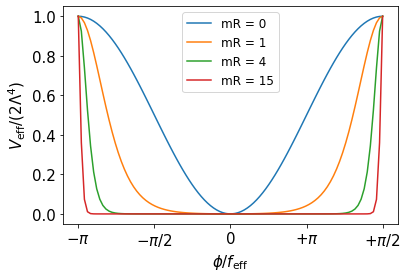

In [5]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6
m_phi = 100 * 1e-9 # [GeV]
eps = calc_eps(mR)
f = 1e12
f_eff = calc_f_eff(f, eps)
M = m_phi / eps 
alpha_range = np.linspace(-np.pi, np.pi, 100)
for plot_mR in [0, 1, 4, 15]:
    eps = calc_eps(plot_mR)
    phi_over_f_range = calc_f_eff(f, eps) * alpha_range / f # not a linear map
    Lambda = np.sqrt(M * f)
    y = calc_V_eff_over_f_sq(phi_over_f_range, eps, M) * f**2 / (2*Lambda**4)
    y[0] = 1; y[-1] = 1 # okay this is bad
    plt.plot(alpha_range, y, label=f"mR = {plot_mR}")
plt.xlabel(r"$\phi / f_\mathrm{eff}$", fontsize=15)
plt.ylabel(r"$V_\mathrm{eff} / (2 \Lambda^4)$", fontsize=15)
plt.legend(fontsize=12)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\pi/2$", "0", r"$+\pi/2$", r"$+\pi$",], fontsize=15)
plt.yticks(fontsize=15);

## Relic Density

step = 1
calculcated initial integration time:
tmax_inf_time = 36.383959044106305 tmax_axion_time = 5.58686371253023e-08
rh: 0.09014725685119629
axion: 0.029593229293823242


/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:66: RuntimeWarning: divide by zero encountered in true_divide
  T_dot = np.where(T == 0, np.inf, T_dot_const * (Gamma * rho_field - 4*H*rho_rad) / T**3)
/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  T_dot = np.where(T == 0, np.inf, T_dot_const * (Gamma * rho_field - 4*H*rho_rad) / T**3)


transport eq.: 0.18729400634765625
change by timescale: 26169987.508860603 vs 0.001
B-L range: -2.436649106878154e-24 0.0
delta = 5.875708560731535 convergence_rtol = 0.001
step = 2
rh: 0.06590700149536133
axion: 0.21923232078552246
transport eq.: 0.5558476448059082
change by timescale: 0.009173936376098644 vs 0.001
B-L range: -1.0726060083140258e-15 -2.43664910687816e-24
delta = 11.882557967310735 convergence_rtol = 0.001
step = 3
rh: 0.0001690387725830078
axion: 0.02403402328491211


/home/jana/Documents/masters-project/transport_eq_in_time/transport_equation.py:150: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)
/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:66: RuntimeWarning: invalid value encountered in double_scalars
  T_dot = np.where(T == 0, np.inf, T_dot_const * (Gamma * rho_field - 4*H*rho_rad) / T**3)


transport eq.: 0.36307740211486816
change by timescale: 0.000574039437681749 vs 0.001
B-L range: -1.0988223476338483e-15 -1.0726060083124102e-15
delta = 0.024394126518069253 convergence_rtol = 0.001
step = 4
rh: 0.0001678466796875
axion: 0.01882457733154297
transport eq.: 0.34238648414611816
change by timescale: 0.00012011083592369401 vs 0.001
B-L range: -1.102014559712457e-15 -1.0988223476334444e-15
delta = 0.002904563123161527 convergence_rtol = 0.001
step = 5
rh: 0.0001666545867919922
axion: 0.016594886779785156


/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  T_dot = np.where(T == 0, np.inf, T_dot_const * (Gamma * rho_field - 4*H*rho_rad) / T**3)
/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:66: RuntimeWarning: divide by zero encountered in true_divide
  T_dot = np.where(T == 0, np.inf, T_dot_const * (Gamma * rho_field - 4*H*rho_rad) / T**3)
No handles with labels found to put in legend.


transport eq.: 0.39684391021728516
change by timescale: 4.139621820595344e-05 vs 0.001
B-L range: -1.10290302149996e-15 -1.102014559712356e-15
delta = 0.0008061767383091117 convergence_rtol = 0.001
advancing to oscillation
t_advance = 230329075.7443773
H = 0.0015274227714186144, H_osc = 2.1708040453599684e-09
delta = nan vs 0.001
delta = 0.0007086764617819535 vs 0.001
relic density took: 1.2982070446014404 seconds


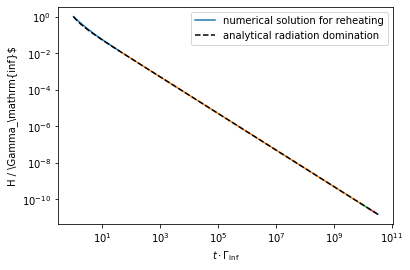

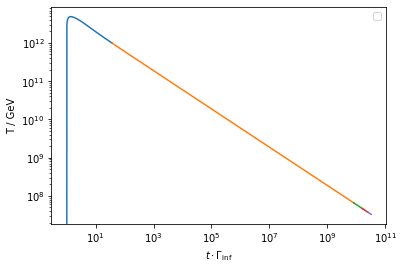

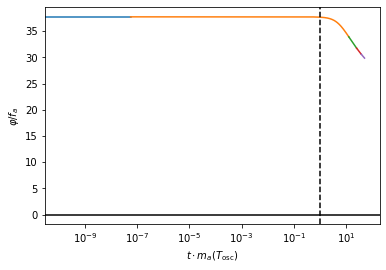

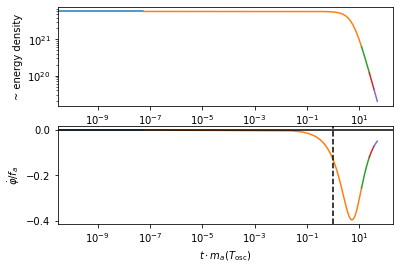

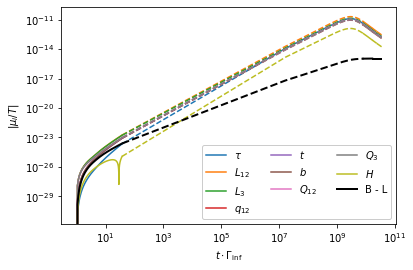

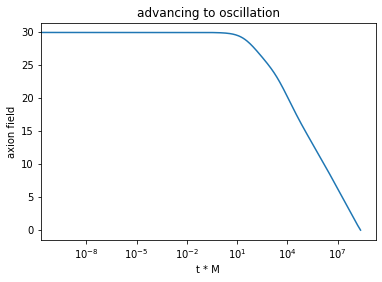

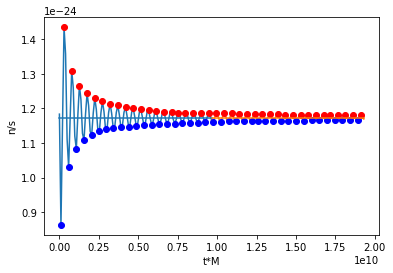

In [36]:
%run convergence.py
%run clockwork_axion.py

mR = 6
m_phi = 1 * 1e-9
f_eff = 1e13
H_inf = 1e8
Gamma_inf = H_inf
eps = calc_eps(mR)
f = calc_f(f_eff, eps)
M = m_phi / eps

eta, dilution, Omega = compute_asymmetry(H_inf, Gamma_inf, (eps, M), f, 
    clockwork_axion_field, axion_init=ax0, calc_init_time=True, debug=True)